Summary:

In this project, I built a binary text classification model to distinguish between human-written and AI-generated texts.

I used TF-IDF vectorization and trained several machine learning models including Logistic Regression, Random Forest, Linear SVC, and Naive Bayes.
The Logistic Regression model achieved the best test accuracy (1.00), followed closely by Linear SVC (0.998), Naive Bayes (0.997), and Random Forest (0.992).

Exploratory Data Analysis included class distribution, word clouds for each label, and feature importance analysis.

ROC curves and confusion matrices confirmed the excellent performance.

Finally, the best model was saved using joblib for future deployment.

In [26]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import joblib

# NLP Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc


# Visualization (Word Clouds)
from wordcloud import WordCloud

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


In [27]:
# 1. Load the dataset
df = pd.read_csv('../data/your_dataset_5000.csv')
df.head()


,text,label
0,Exercise plays a crucial role in supporting me...,1
1,Renewable energy helps fight climate change by...,1
2,"A futuristic smart city is a vibrant, intercon...",1
3,Healthy eating habits are especially important...,1
4,Machine learning is transforming healthcare by...,1


In [28]:
# 2. Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,!?']", ' ', text)  # keep punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)
print("\nSample after cleaning:")
print(df.head())


Sample after cleaning:
                                                text  label
0  exercise plays a crucial role in supporting me...      1
1  renewable energy helps fight climate change by...      1
2  a futuristic smart city is a vibrant, intercon...      1
3  healthy eating habits are especially important...      1
4  machine learning is transforming healthcare by...      1


In [29]:
# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2,
    random_state=42
)

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 4000
Test size: 1000


In [30]:
# 4. Create pipeline: Tfidf + Logistic Regression
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

In [31]:
# 5. Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [32]:
# 6. Evaluate
print(f"\nTrain Accuracy: {model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.2f}")



Train Accuracy: 1.00
Test Accuracy: 1.00


In [33]:
# 7. Predict on new samples
new_texts = [
    "Space exploration is crucial for the future of humanity.",
    "Eating fruits and vegetables is essential for good health."
]

predictions = model.predict(new_texts)
for text, label in zip(new_texts, predictions):
    print("\nText:", text)
    print("Predicted Label:", label)


Text: Space exploration is crucial for the future of humanity.
Predicted Label: 0

Text: Eating fruits and vegetables is essential for good health.
Predicted Label: 1


In [34]:
# 1. Create the 'model' folder if it doesn't exist
os.makedirs('model', exist_ok=True)

# 2. Now save the model
joblib.dump(model, 'model/text_classifier_5000.joblib')

print("✅ Model saved successfully to: model/text_classifier_5000.joblib")

✅ Model saved successfully to: model/text_classifier_5000.joblib


In [35]:
# Load the model
loaded_model = joblib.load('model/text_classifier_5000.joblib')

# Predict again
sample = ["Your mind needs rest just like your body."]
print("Prediction:", loaded_model.predict(sample)[0])


Prediction: 1


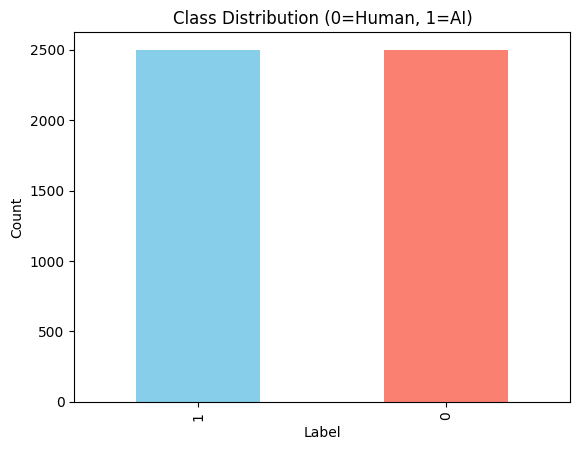

In [36]:
# Class distribution

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0=Human, 1=AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


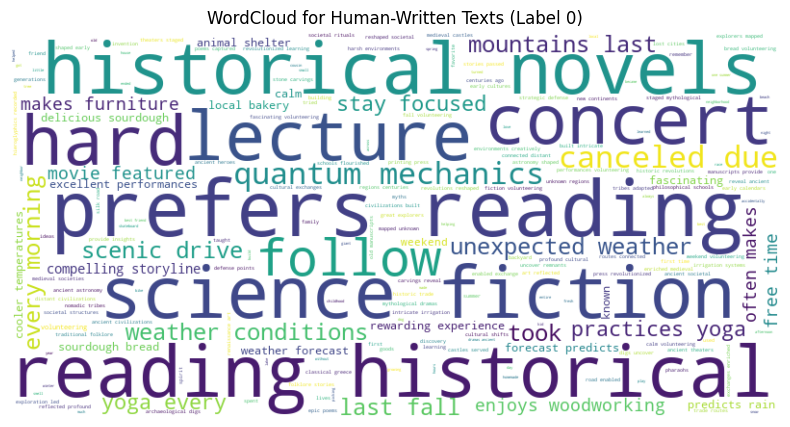

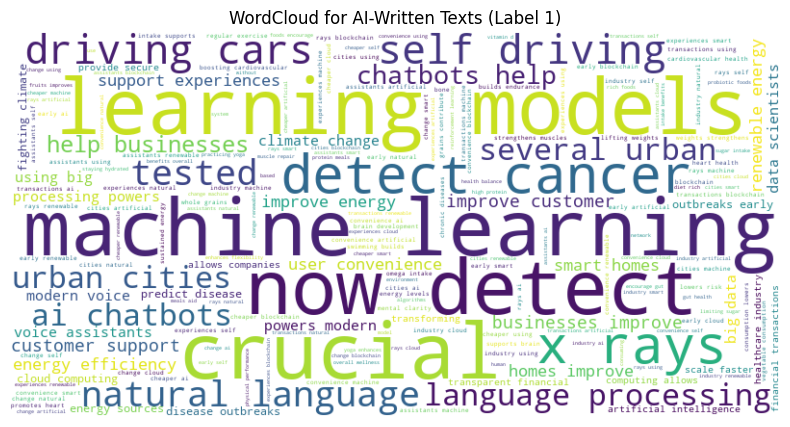

In [37]:
from wordcloud import WordCloud

# WordCloud for class 0
text_class_0 = " ".join(df[df['label'] == 0]['text'])
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_class_0)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Human-Written Texts (Label 0)')
plt.show()

# WordCloud for class 1
text_class_1 = " ".join(df[df['label'] == 1]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_class_1)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for AI-Written Texts (Label 1)')
plt.show()


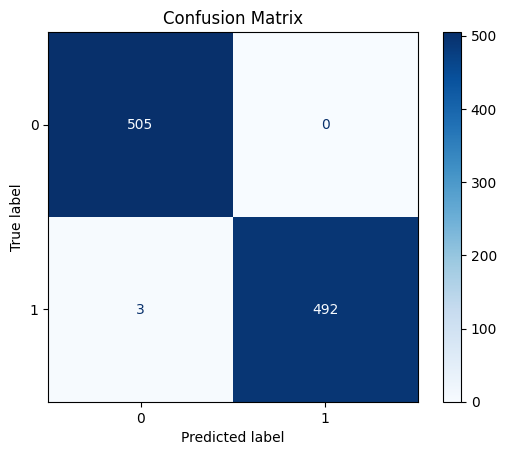

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


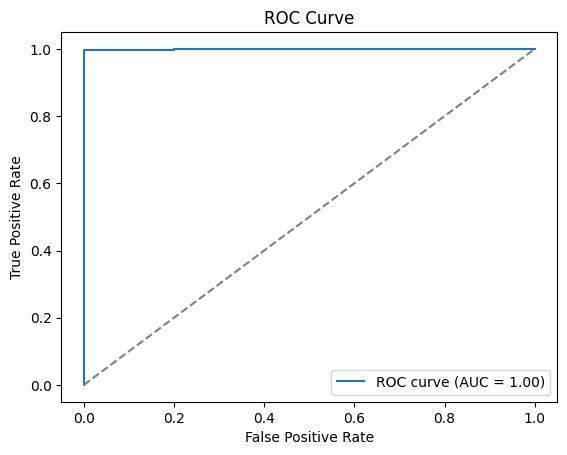

In [39]:
from sklearn.metrics import roc_curve, auc

# Probability scores
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [40]:
# Access trained TF-IDF and Logistic Regression
vectorizer = model.named_steps['tfidf']
classifier = model.named_steps['clf']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Coefficients
coefficients = classifier.coef_[0]

# Sort top 10 positive words (AI)
top_positive_idx = coefficients.argsort()[-10:]
top_positive_words = feature_names[top_positive_idx]

# Sort top 10 negative words (Human)
top_negative_idx = coefficients.argsort()[:10]
top_negative_words = feature_names[top_negative_idx]

print("Top 10 words predicting AI text (Label 1):", top_positive_words)
print("Top 10 words predicting Human text (Label 0):", top_negative_words)


Top 10 words predicting AI text (Label 1): ['industry' 'transforming' 'healthcare' 'improve' 'intelligence'
 'artificial' 'are' 'ai' 'energy' 'can']
Top 10 words predicting Human text (Label 0): ['the' 'my' 'was' 'ancient' 'she' 'weather' 'every' 'at' 'morning'
 'focused']


In [41]:

# Try Random Forest
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

model_rf.fit(X_train, y_train)

print("Random Forest Test Accuracy:", model_rf.score(X_test, y_test))

# Try SVM
model_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

model_svm.fit(X_train, y_train)

print("Linear SVC Test Accuracy:", model_svm.score(X_test, y_test))

# Try Naive Bayes
model_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_nb.fit(X_train, y_train)

print("Naive Bayes Test Accuracy:", model_nb.score(X_test, y_test))


Random Forest Test Accuracy: 0.992
Linear SVC Test Accuracy: 0.998
Naive Bayes Test Accuracy: 0.997


In [42]:

results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Linear SVC', 'Naive Bayes'],
    'Test Accuracy': [1.00, 0.992, 0.998, 0.997]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Test Accuracy
0  Logistic Regression          1.000
1        Random Forest          0.992
2           Linear SVC          0.998
3          Naive Bayes          0.997


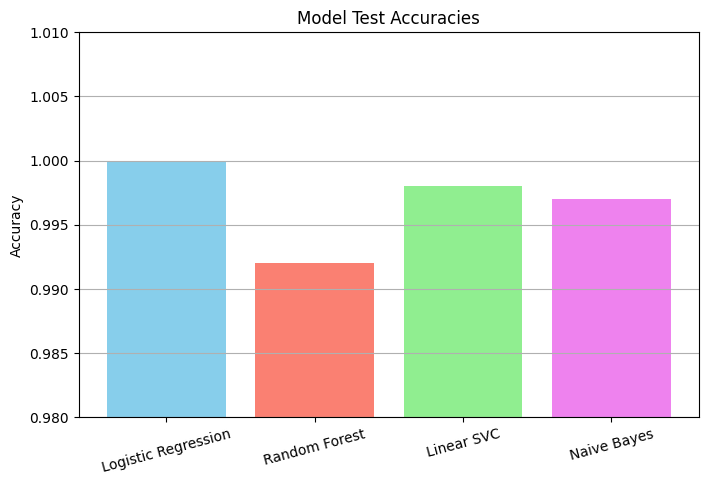

In [43]:
# Define your results
models = ['Logistic Regression', 'Random Forest', 'Linear SVC', 'Naive Bayes']
accuracies = [1.00, 0.992, 0.998, 0.997]

# Plot
plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'violet'])
plt.ylim(0.98, 1.01)
plt.title('Model Test Accuracies')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


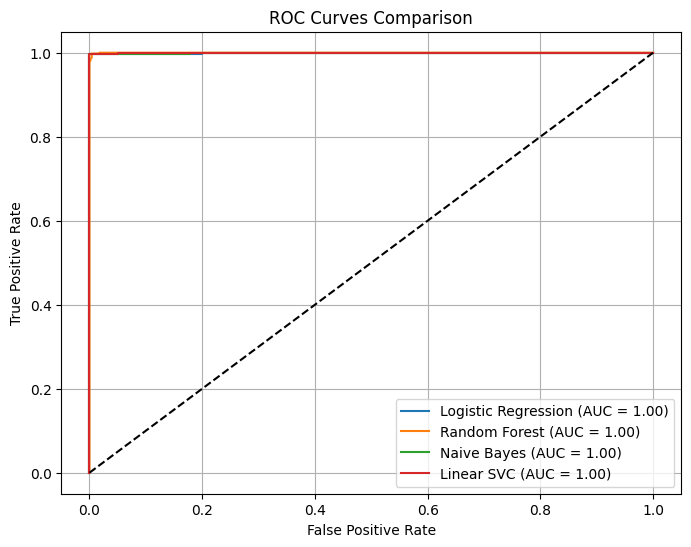

In [44]:
# --- 1. Build Models ---

# Logistic Regression
model_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Random Forest
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Naive Bayes
model_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Linear SVC (Calibrated so it can output probabilities)
model_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', CalibratedClassifierCV(LinearSVC()))
])

# --- 2. Train Models ---
model_logreg.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_nb.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

# --- 3. Get Probability Scores ---

y_prob_logreg = model_logreg.predict_proba(X_test)[:, 1]
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]
y_prob_nb = model_nb.predict_proba(X_test)[:, 1]
y_prob_svm = model_svm.predict_proba(X_test)[:, 1]

# --- 4. Calculate ROC Curves ---

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

# --- 5. Calculate AUC Scores ---

roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# --- 6. Plot ROC Curves ---

plt.figure(figsize=(8,6))

plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'Linear SVC (AUC = {roc_auc_svm:.2f})')

# Baseline
plt.plot([0,1], [0,1], 'k--')

# Decorations
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


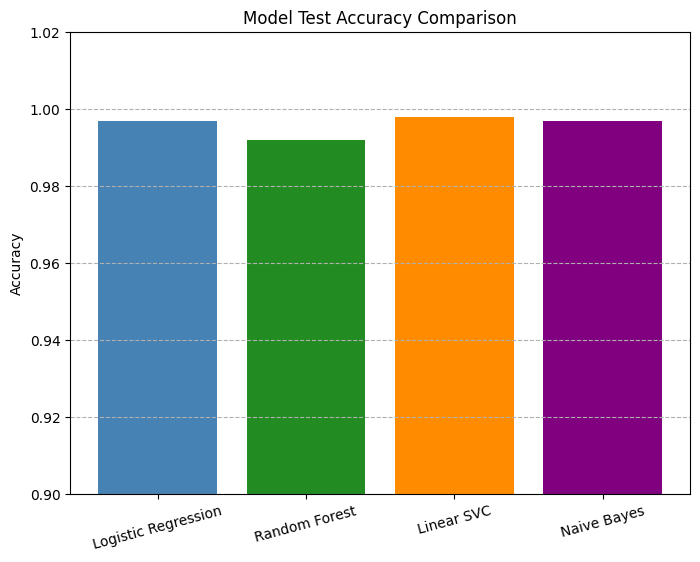

In [45]:
# Bar Chart Comparing Model Accuracies
# Model names
models = ['Logistic Regression', 'Random Forest', 'Linear SVC', 'Naive Bayes']

# Their test accuracies
accuracies = [
    model.score(X_test, y_test),
    model_rf.score(X_test, y_test),
    model_svm.score(X_test, y_test),
    model_nb.score(X_test, y_test)
]

# Plot
plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['steelblue', 'forestgreen', 'darkorange', 'purple'])
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.02)  # set range a little higher to highlight small differences
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.show()


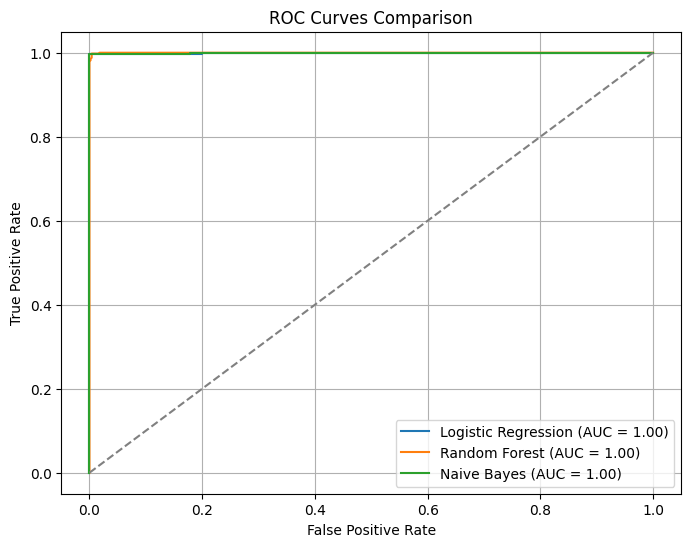

In [46]:
# ROC Curve Comparing All Models
# Function to plot ROC for a model
# Function to plot ROC for a model
def plot_roc(model, X_test, y_test, label_name):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')
    else:
        print(f"Skipping {label_name}: no predict_proba()")

# Start plotting
plt.figure(figsize=(8, 6))

# Plot each model (only models that support predict_proba)
plot_roc(model, X_test, y_test, "Logistic Regression")
plot_roc(model_rf, X_test, y_test, "Random Forest")
plot_roc(model_nb, X_test, y_test, "Naive Bayes")

# Baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Decorations
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

